In [1]:
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.circuit.library import RealAmplitudes, NLocal
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter, ParameterVector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.transpiler.passes import RemoveBarriers
import qiskit.quantum_info as qi
import numpy as np
from scipy.optimize import minimize
from scipy.stats import unitary_group
import random

Main part

In [2]:
base = 1 #Base gate 0: all, 1: X, RZ, SX, ECR
GlobalPhase = 0

#Simple gates
def H (q, cir):
    if(base == 0):
        cir.h(q)
    else:
        cir.sx(q)
        cir.rz(np.pi/2, q)
        cir.sx(q)
    return cir

def ZY (q, cir):
    if(base == 0):
        cir.z(q)
        cir.y(q)
    else:
        cir.x(q)
        cir.rz(np.pi, q)
        cir.sx(q)
        cir.rz(-np.pi, q)
        cir.sx(q)
    return cir

def RY (phi, q, cir):
    if(base == 0):
        cir.ry(phi, q)
    else:
        cir.sx(q)
        cir.rz(phi, q)
        cir.x(q)
        cir.sx(q)
    return cir

def CX (q, c, cir):
    if(base == 0):
        cir.cx(q, c)
    else:
        cir.rz(np.pi, q)
        cir.sx(q)
        cir.sx(c)
        cir.rz(np.pi, c)
        cir.ecr(q, c)
        cir.rz(np.pi, q)
        cir.sx(q)
        cir.sx(c)
        cir.rz(np.pi, c)
        cir.ecr(q, c)
        cir.rz(np.pi, q)
        cir.sx(q)
        cir.rz(-np.pi/2, q)
        cir.sx(c)
        global GlobalPhase
        GlobalPhase += (-1)*np.pi/4
    return cir

In [3]:
#n-bit gates
def X_bit_mask(x_mask, q_list, cir):
    i = 0
    while (x_mask != 0):
        if(x_mask & 1):
            cir.x(q_list[i])
        i = i + 1
        x_mask = x_mask >> 1
    
    return cir

def CNOT_lin(q0, c, q_list, cir, flag_non_lin = False):
    if(flag_non_lin or abs(q0 - c) == 1):
        cir = CX(q_list[q0], q_list[c], cir)
    else:
        i = 0
        while(q0 + i < c):
            cir = CX(q_list[q0 + i], q_list[q0 + i + 1], cir)
            i+=1

        i -= 2
        while(i > 0):
            cir = CX(q_list[q0 + i], q_list[q0 + i + 1], cir)
            i-=1

        while(q0 + i < c):
            cir = CX(q_list[q0 + i], q_list[q0 + i + 1], cir)
            i+=1

        i -= 2
        while(i > 0):
            cir = CX(q_list[q0 + i], q_list[q0 + i + 1], cir)
            i-=1

    return cir

def C2NOT(q0, q1, c, q_list, cir): #CCNOT if P -> GF = 0, RZ -> GF = pi/8
    cir = H(q_list[c], cir)
    cir = CNOT_lin(q1, c, q_list, cir)
    cir.rz(-np.pi/4, q_list[c])
    cir = CNOT_lin(q0, c, q_list, cir)
    cir.rz(np.pi/4, q_list[c])
    cir = CNOT_lin(q1, c, q_list, cir)
    cir.rz(-np.pi/4, q_list[c])
    cir.rz(np.pi/4, q_list[q1])
    cir = CNOT_lin(q0, c, q_list, cir)
    cir.rz(np.pi/4, q_list[c])
    cir = CNOT_lin(q0, q1, q_list, cir)
    cir.rz(-np.pi/4, q_list[q1])
    cir.rz(np.pi/4, q_list[q0])
    cir = CNOT_lin(q0, q1, q_list, cir)
    cir = H(q_list[c], cir)

    global GlobalPhase 
    GlobalPhase += np.pi/8

    return cir

def CP_(phi, q, c, q_list, cir): #Controled P

    cir.rz(phi/2, q_list[q])
    cir = CNOT_lin(q, c, q_list, cir)
    cir.rz(-phi/2, q_list[c])
    cir = CNOT_lin(q, c, q_list, cir)
    cir.rz(phi/2, q_list[c])

    global GlobalPhase
    GlobalPhase += (-1)*phi/4

    return cir

def CnPhase(ang, list, c, q_list, cir): #Multi controled P

    if(len(list) == 1):
        cir = CP_(ang, list[0], c, q_list, cir)
        return cir

    for i in range(1, len(list)):
        cir = CP_(ang/(2**i), list[-i], c, q_list, cir)
        cir = CnNOT(list[:-i], list[-i], q_list, cir)

        cir = CP_(-ang/(2**i), list[-i], c, q_list, cir)
        cir = CnNOT(list[:-i], list[-i], q_list, cir)

    cir = CP_(ang/(2**(len(list) - 1)), list[0], c, q_list, cir)

    return cir


def CnNOT(list, c, q_list, cir):

    if(len(list) == 1):
        cir = CNOT_lin(list[0], c, q_list, cir)
    elif(len(list) == 2):
        cir = C2NOT(list[0], list[1], c, q_list, cir)
    else:
        cir = H(q_list[c], cir)
        cir = CnPhase(np.pi, list, c, q_list, cir)
        cir = H(q_list[c], cir)

    return cir

def CSWAP(q0, q1, c, q_list, cir):

    cir = CNOT_lin(q1, q0, q_list, cir)
    cir = C2NOT(q0, q1, c, q_list, cir)
    cir = CNOT_lin(q1, q0, q_list, cir)
    return cir

In [4]:
#Auxiliary algorithms
def norm(vec): #norm state vector
    sum = 0
    for elem in vec:
        sum += abs(elem)**2
    sum = np.sqrt(sum)
    return [x / sum for x in vec]

def abs_ang(vec, q_list): #abs angles
    step = len(vec)
    level_ang = []
    temp_vec = [abs(x) for x in norm(vec)]

    for i in range(len(q_list)):
        step //= 2
        level_ang.append([])
        new_vec = []
        for j in range(step):
            a = temp_vec[j]
            b = temp_vec[j+step]
            c = np.sqrt(a**2 + b**2)
            new_vec.append(c)
            if (c != 0):
                level_ang[i].append(2*np.arccos(a/c))
            else:
                level_ang[i].append(0)
        temp_vec = new_vec
    
    return(level_ang)

def phase_ang(vec): #phase angles
    level_ang = []

    for i in range(len(vec)):
        temp_ang = np.angle(vec[i])
        if (temp_ang < 0):
            temp_ang += (2*np.pi)
        level_ang.append(temp_ang)
    
    return(level_ang)

In [5]:
# State preparation algorithm
def run(vec, q_list):
    global GlobalPhase
    N_ = len(q_list)
    cir = QuantumCircuit(N_)
    
    
    level_angles = list(reversed(abs_ang(vec, q_list)))
    phase = phase_ang(vec)

    angle = level_angles[0]
    if(angle[0] != 0):
        cir = RY(angle[0], q_list[0], cir)
    if(N_ == 1):
        if(phase[1] != 0):
            cir.rz(-phase[0] + phase[1], q_list[0])
        GlobalPhase += (phase[0] + phase[1])/2

    temp = [0]

    for i in range(1, N_):
        angles = level_angles[i]
        last_0 = 2**i - 1 

        for j in range(2**(i)):
            if(j == 0 or angles[j] != 0 or i == N_-1):
                cir = X_bit_mask((2**(i) - j - 1) ^ (2**(i) - last_0 - 1), q_list, cir)
                last_0 = j

            if(i == N_-1 and phase[j] != 0):
                cir.rz((-1.)*phase[j], q_list[i])
            if(i == N_-1 and phase[j+2**(i)] != 0):
                cir.x(q_list[i])
                cir.rz(phase[j+2**(i)], q_list[i])
                cir.x(q_list[i])

            cir = RY(angles[j]/2, q_list[i], cir)

            cir = CnNOT(temp, i, q_list, cir)

            cir = RY((-1)*angles[j]/2, q_list[i], cir)
            
            if(i == N_-1 and phase[j] != 0):
                cir.rz(phase[j], q_list[i])

            cir = CnNOT(temp, i, q_list, cir)

            if(i == N_-1 and phase[j+2**(i)] != 0):
                cir.x(q_list[i])
                cir.rz((-1)*phase[j+2**(i)], q_list[i])
                cir.x(q_list[i])

        cir = X_bit_mask(2**(i) - last_0 - 1, q_list, cir) 
        temp.append(i)

    GlobalPhase = GlobalPhase % (2*np.pi)
    while(GlobalPhase - np.pi/2 >= -0.00001):
        cir.x(q_list[0])
        cir = ZY(q_list[0], cir)
        GlobalPhase -= np.pi/2

    if(GlobalPhase - np.pi/4 > -np.pi/8 and len(q_list) > 2):
        cir = C2NOT(0, 1, 2, q_list, cir)
        cir = C2NOT(0, 1, 2, q_list, cir)
        cir.x(q_list[0])
        cir = ZY(q_list[0], cir)
        GlobalPhase -= np.pi/2

    print("gp: ", GlobalPhase)
    GlobalPhase = 0

    return cir

gp:  0.0


Samples

In [6]:
N_q = 2
size_v = 2**N_q
a = np.random.uniform(low=-1, high=1, size=size_v).tolist()
b = np.random.uniform(low=-1, high=1, size=size_v).tolist()
vec = norm([complex(a[i], b[i]) for i in range(size_v)])
cir = run(vec, [i for i in range(N_q)])
op = qi.Operator(cir)
array = np.array(op.data)
res = array[:, 0]
print(np.array(vec))
print(res.flatten())
print(np.linalg.norm(np.array(vec) - res.flatten()))

[-0.13235243+0.51027599j -0.10799557+0.47295114j  0.48373083+0.22057838j
 -0.34645986-0.28994939j]
[-0.13235243+0.51027599j -0.10799557+0.47295114j  0.48373083+0.22057838j
 -0.34645986-0.28994939j]
1.0138386515217635e-15


In [9]:
N_q = 3
size_v = 2**N_q

vec = norm([1, 0, 0, 1, 1, 2, 3, 4])
print(list(reversed(abs_ang(vec, [0,1,2]))))
cir = run(vec, [i for i in range(N_q)])
cir = RemoveBarriers()(cir)
print(dict(cir.count_ops()))
op = qi.Operator(cir)
array = np.array(op.data)
res = array[:, 0]
print(np.array(vec))
print(res.flatten())
print(np.linalg.norm(np.array(vec) - res.flatten()))

[[1.8886200307227774], [2.2605713275803963, 2.2383257714307296], [1.5707963267948966, 3.141592653589793, 3.141592653589793, 2.651635327336065]]
gp:  1.1368683772161603e-13
{'rz': 685, 'sx': 658, 'ecr': 200, 'x': 21}
[0.1767767  0.         0.         0.1767767  0.1767767  0.35355339
 0.53033009 0.70710678]
[ 1.76776695e-01-3.60822483e-16j -6.10622664e-16-6.38378239e-16j
  0.00000000e+00-1.11022302e-16j  1.76776695e-01-1.66533454e-16j
  1.76776695e-01+5.27355937e-16j  3.53553391e-01-1.60982339e-15j
  5.30330086e-01+1.11022302e-16j  7.07106781e-01-1.38777878e-15j]
2.2082294793869584e-14


In [11]:
print(array) 

[[ 1.76776695e-01-3.60822483e-16j -2.44252105e-01+8.32667268e-17j
  -3.75000000e-01+2.22044605e-16j  5.18136960e-01+7.77156117e-16j
  -1.76776695e-01-3.33066907e-16j  2.44252105e-01+4.85722573e-16j
   3.75000000e-01-1.72084569e-15j -5.18136960e-01-2.22044605e-16j]
 [-6.10622664e-16-6.38378239e-16j  1.38777878e-16+5.27355937e-16j
  -5.55111512e-17-2.22044605e-16j  1.66533454e-16-1.11022302e-15j
  -3.53553391e-01+8.32667268e-17j -2.55883158e-01-1.60982339e-15j
   7.28868987e-01-4.99600361e-16j  5.27516644e-01-2.22044605e-16j]
 [ 0.00000000e+00-1.11022302e-16j  5.55111512e-16-2.77555756e-16j
   2.77555756e-17+1.38777878e-16j -3.33066907e-16-7.21644966e-16j
  -5.30330086e-01+4.44089210e-16j  7.32756316e-01+1.38777878e-15j
  -2.50000000e-01+4.71844785e-16j  3.45424640e-01-7.49400542e-16j]
 [ 1.76776695e-01-1.66533454e-16j  1.27941579e-01+6.10622664e-16j
   8.57492926e-02-8.88178420e-16j  6.20607816e-02+1.80411242e-16j
  -7.07106781e-01+8.32667268e-16j -5.11766316e-01-1.66533454e-16j
  -3.42

Qiskit AerSim

{'000': 124, '101': 509, '111': 2056, '110': 1150, '011': 139, '100': 118}


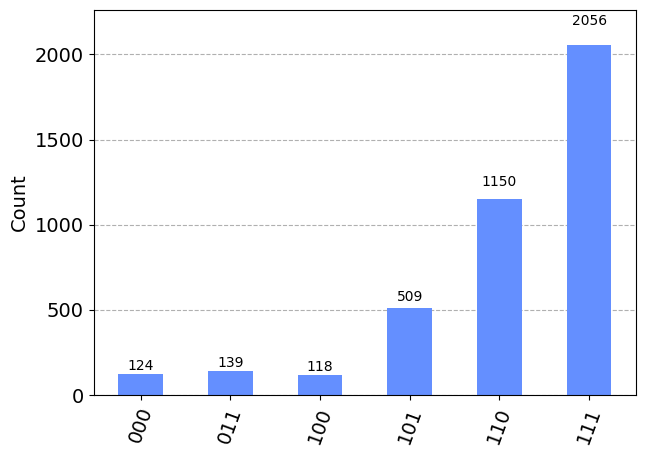

In [13]:
cir.measure_all()
shots = 4096
aer_sim = AerSimulator()
#cir = transpile(cir, aer_sim)
#cir.draw('mpl', style="iqp")
result_sim = aer_sim.run(cir, shots=shots).result()
countsU = result_sim.get_counts(cir)
print(countsU)
plot_histogram(countsU)

IBM quantum

In [8]:
#QiskitRuntimeService.save_account(channel="ibm_quantum", overwrite=True, token="")
service = QiskitRuntimeService()
#print(service.backends())
backend = service.get_backend('ibm_sherbrooke')

In [ ]:
transpiled_circuit = transpile(cir, backend)
transpiled_circuit.draw('mpl', style="iqp")

C:\Users\Александр\AppData\Local\Temp\ipykernel_20956\366348298.py:1: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  job = backend.run(transpiled_circuit, shots=shots)


{'01': 111, '00': 2035, '10': 124, '11': 1826}


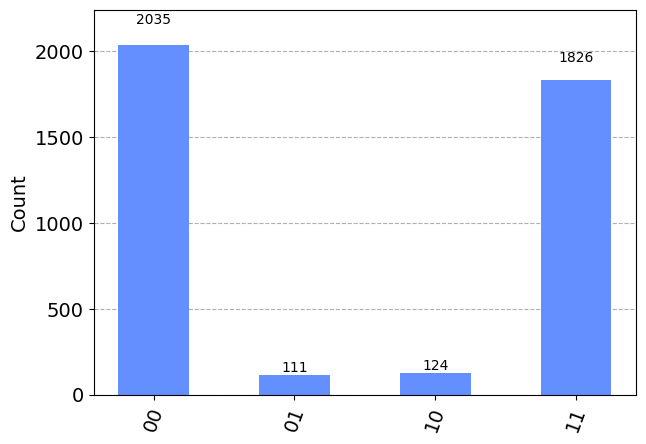

In [ ]:
job = backend.run(transpiled_circuit, shots=shots)
counts_q = job.result().get_counts()
print(counts_q)
plot_histogram(counts_q)

Experiments

In [45]:
Num_exp = 3
Max_q = 6

res_list = []
for j in range(Max_q):
    res_list.append([complex(0, 0)] * Num_exp)

for i in range(Num_exp):
    print("Num_exp: ", i, '\n')
    for j in range(0, Max_q):
        N_q = j+1
        size_v = 2**N_q
        print("Num_q: ", N_q)
        a = np.random.uniform(low=-1, high=1, size=size_v).tolist()
        b = np.random.uniform(low=-1, high=1, size=size_v).tolist()
        #b = np.array([0] * size_v)
        vec = norm([complex(a[i], b[i]) for i in range(size_v)])
        cir = run(vec, [i for i in range(N_q)])
        op = qi.Operator(cir)
        array = np.array(op.data)
        res = array[:, 0]
        res_list[j][i] = np.linalg.norm(np.array(vec) - res.flatten())
        print("e: ", res_list[j][i])

Num_exp:  0 

Num_q:  6
gp:  -18.26050723250495
e:  0.765366864735325
Num_exp:  1 

Num_q:  6
gp:  3.917172719525297e-08
e:  1.1449667965009107e-11
Num_exp:  2 

Num_q:  6
gp:  3.917172719525297e-08
e:  1.1443651254765448e-11


In [46]:
mid_res = [sum(res_list[i])/Num_exp for i in range(Max_q)]
print(mid_res)

[0j, 0j, 0j, 0j, 0j, 0.2551222882527394]


In [ ]:
res_list_mod = []
for j in range(Max_q):
    res_list_mod.append([complex(0, 0)] * Num_exp)

for i in range(Num_exp):
    print("Num_exp: ", i, '\n')
    for j in range(Max_q):
        N_q = j+1
        size_v = 2**N_q
        print("Num_q: ", N_q)
        a = np.random.uniform(low=0, high=1, size=size_v).tolist()
        #b = np.random.uniform(low=-1, high=1, size=size_v).tolist()
        #b = np.array([0] * size_v)
        vec = norm([a[i] for i in range(size_v)])
        cir = run(vec, [i for i in range(N_q)])
        op = qi.Operator(cir)
        array = np.array(op.data)
        res = array[:, 0]
        res_list_mod[j][i] = np.linalg.norm(np.array(vec) - res.flatten())
        print("e: ", res_list_mod[j][i])

Num_exp:  0 

Num_q:  1
gp:  0.0
e:  1.1102230246251565e-16
Num_q:  2
gp:  0.0
e:  9.477624839917472e-16
Num_q:  3
gp:  1.1368683772161603e-13
e:  2.1517730681247506e-14
Num_q:  4
gp:  5.936584557275637e-12
e:  2.2618303152827177e-13
Num_q:  5
gp:  8.416165542257659e-10
e:  1.7364067566012113e-12
Num_exp:  1 

Num_q:  1
gp:  0.0
e:  1.6653345369377348e-16
Num_q:  2
gp:  0.0
e:  6.901322157724297e-16
Num_q:  3
gp:  1.1368683772161603e-13
e:  2.165231115147697e-14
Num_q:  4
gp:  5.936584557275637e-12
e:  2.2469910383823255e-13
Num_q:  5
gp:  8.416165542257659e-10
e:  1.7336736287957599e-12
Num_exp:  2 

Num_q:  1
gp:  0.0
e:  1.2412670766236366e-16
Num_q:  2
gp:  0.0
e:  8.28028417508636e-16
Num_q:  3
gp:  1.1368683772161603e-13
e:  2.1194422926589407e-14
Num_q:  4
gp:  5.936584557275637e-12
e:  2.258906877038217e-13
Num_q:  5
gp:  8.416165542257659e-10
e:  1.7265415316267875e-12
Num_exp:  3 

Num_q:  1
gp:  0.0
e:  1.5700924586837752e-16
Num_q:  2
gp:  0.0
e:  6.574396000919821e-16
Num_

In [ ]:
mid_res_mod = [sum(res_list_mod[i])/Num_exp for i in range(Max_q)]
print(mid_res_mod)

[1.5856480074653e-16, 8.94056265674796e-16, 2.1192238932002667e-14, 2.2548581230251933e-13, 1.7340006747999462e-12]


In [9]:
def dec_U(U, rot, ent, reps, phase = None):
    size_v = U[0].size
    num_q = int(np.log2(size_v))
    if(num_q == 1):
        qc_nlocal = NLocal(num_qubits=1, rotation_blocks=rot, entanglement='linear',
                    skip_final_rotation_layer=True, insert_barriers=True, reps=reps)
    else:
        qc_nlocal = NLocal(num_qubits=num_q, rotation_blocks=rot,
                    entanglement_blocks=ent, entanglement='linear',
                    skip_final_rotation_layer=True, insert_barriers=True, reps=reps)

    qc_nlocal = qc_nlocal.decompose()
    if(num_q != 1 and reps != 1):
        for i in range(num_q-1):
            qc_nlocal.data.pop()

    if (phase != None):# and num_q == 1
        #qc_nlocal.add_layer(phase, front = True)
        params_p = ParameterVector('p', 1)
        qc_nlocal.p(params_p[0], 0)
        qc_nlocal.x(0)
        qc_nlocal.p(params_p[0], 0)
        qc_nlocal.x(0)
    
    #qc_nlocal.draw('mpl', style="iqp")#'mpl', style="iqp"
    return qc_nlocal



def dec_run(U, rot, ent, reps, param0 = None, phase = None, Nmax = 1):
    qc_nlocal = dec_U(U, rot, ent, reps, phase)
    param_size = qc_nlocal.num_parameters
    print("param_size: ", param_size)

    def loss(param):
        op_param = qi.Operator(qc_nlocal.assign_parameters(param))
        array_param = op_param.data
        norm_ = np.linalg.norm(np.array(U) - np.array(array_param), ord = 'fro')
        return norm_
    
    bounds = [[-np.pi, np.pi] for i in range(param_size)]
    if (param0 == None):
        param0 = np.random.uniform(low=-np.pi, high=np.pi, size=param_size).tolist()
        
    res = minimize(loss, param0, bounds=bounds)
    count = 1
    min_e = loss(res.x)
    min_p = res.x
    while (min_e > 0.000001 and count < Nmax):
        param0 = np.random.uniform(low=-np.pi, high=np.pi, size=param_size).tolist()
        res = minimize(loss, param0, bounds=bounds)
        if(loss(res.x) < min_e):
            min_e = loss(res.x)
            min_p = res.x
        count+=1
    param = np.array(min_p)
    tmp = list(np.around(param,3))
    gp = tmp.pop()
    print("param: ", tmp)
    e = min_e
    print("e: ", e)
    print("gp: ", gp)
    qc_nlocal.assign_parameters(min_p).draw()
    return [qc_nlocal, param, e]

# rotation block:
rot = QuantumCircuit(1)
params = ParameterVector('r', 3)
rot.sx(0)
rot.rz(params[0], 0)
rot.sx(0)
rot.rz(params[1], 0)
rot.sx(0)
rot.rz(params[2], 0)
rot.sx(0)

# entanglement block:
ent = QuantumCircuit(2)
ent.ecr(0, 1)

In [55]:
#mid_res_a = [sum(res_list_a[i])/Num_exp for i in range(Max_q)]
#print(mid_res_a)
#mid_res_b = [sum(res_list_b[i])/Num_exp for i in range(Max_q)]
#print(mid_res_b)

[0.8184334841737559, 1.149589442747181e-15, 2.1531059102313306e-14]
[0.8184334854672994, 1.4095688573315571e-08, 4.539507249031361e-07]


In [62]:
Max_q = 7

for i in range(1):
    print("Num_exp: ", i, '\n')
    for j in range(0, Max_q):
        N_q = j+1
        size_v = 2**N_q
        print("Num_q: ", N_q)
        a = np.random.uniform(low=-1, high=1, size=size_v).tolist()
        b = np.random.uniform(low=-1, high=1, size=size_v).tolist()
        #b = np.array([0] * size_v)
        vec = norm([complex(a[i], b[i]) for i in range(size_v)])
        cir = run(vec, [i for i in range(N_q)])
        print(cir.size(), cir.count_ops())
        num_q = int(np.log2(size_v))
        if(N_q == 1):
            qc_nlocal = NLocal(num_qubits=1, rotation_blocks=rot, entanglement='linear',
                        skip_final_rotation_layer=True, insert_barriers=True, reps=size_v)
        else:
            qc_nlocal = NLocal(num_qubits=N_q, rotation_blocks=rot,
                        entanglement_blocks=ent, entanglement='linear',
                        skip_final_rotation_layer=True, insert_barriers=True, reps=size_v)
        qc_nlocal = qc_nlocal.decompose()
        print(qc_nlocal.size(), qc_nlocal.count_ops())

Num_exp:  0 

Num_q:  1
gp:  0.7103297599085585
5 OrderedDict([('ry', 1), ('rz', 1), ('x', 1), ('z', 1), ('y', 1)])
14 OrderedDict([('sx', 8), ('rz', 6), ('barrier', 3)])
Num_q:  2
gp:  0.0
27 OrderedDict([('x', 10), ('rz', 8), ('ry', 5), ('cx', 4)])
60 OrderedDict([('sx', 32), ('rz', 24), ('barrier', 7), ('ecr', 4)])
Num_q:  3
gp:  0.0
183 OrderedDict([('rz', 72), ('cx', 52), ('x', 26), ('h', 16), ('ry', 13), ('z', 2), ('y', 2)])
184 OrderedDict([('sx', 96), ('rz', 72), ('ecr', 16), ('barrier', 15)])
Num_q:  4
gp:  2.1316282072803006e-14
1183 OrderedDict([('rz', 552), ('cx', 436), ('h', 112), ('x', 54), ('ry', 29)])
496 OrderedDict([('sx', 256), ('rz', 192), ('ecr', 48), ('barrier', 31)])
Num_q:  5
gp:  -2.4513724383723456e-13
7299 OrderedDict([('rz', 3560), ('cx', 2868), ('h', 688), ('x', 118), ('ry', 61), ('z', 2), ('y', 2)])
1248 OrderedDict([('sx', 640), ('rz', 480), ('ecr', 128), ('barrier', 63)])
Num_q:  6
gp:  -7.666756118851481e-12
44103 OrderedDict([('rz', 21864), ('cx', 1771

Num_q:  2
gp:  0.0
param_size:  24
param:  [-3.018, 3.142, 1.449, -0.717, -0.0, -2.599, 2.764, 3.142, 1.949, -3.142, -1.571, 3.141, -2.286, -3.142, -2.426, -3.142, -3.14, -3.142, -1.965, 3.142, 0.394, -3.142, -3.142]
e:  4.1439247781157965e-08
gp:  0.311
59 OrderedDict([('sx', 32), ('rz', 24), ('barrier', 7), ('ecr', 3)])


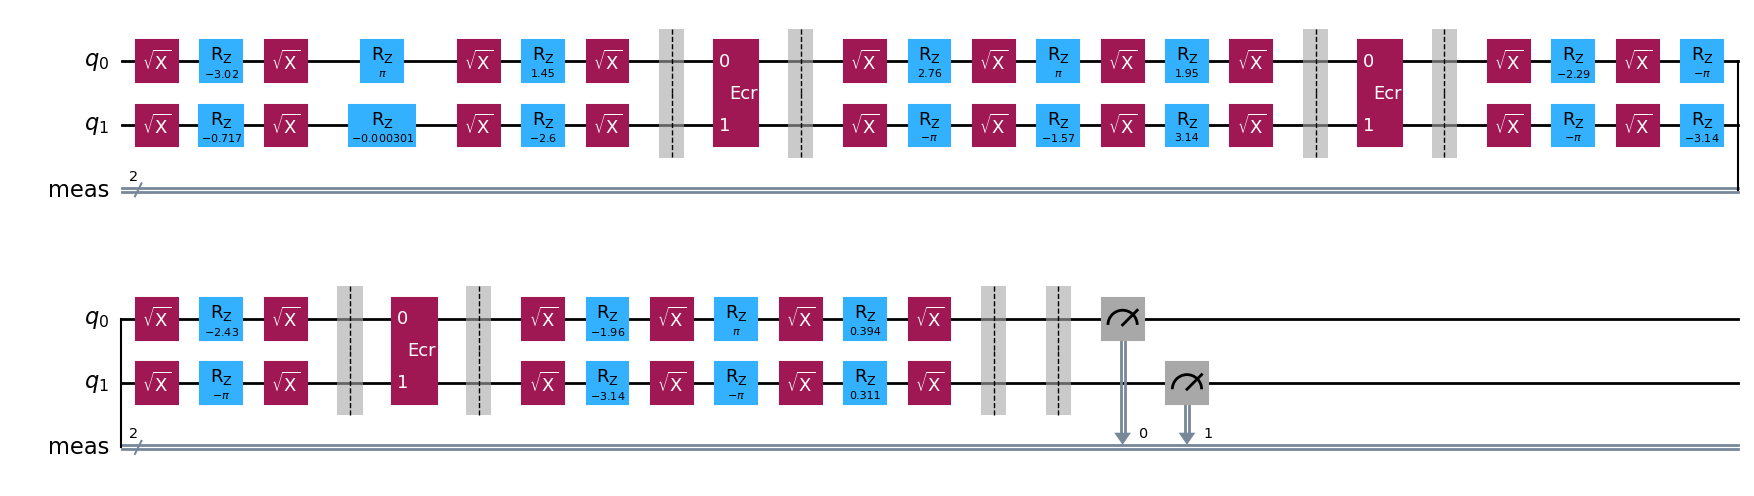

In [18]:
N_q = 2
size_v = 2**N_q
print("Num_q: ", N_q)
vec = norm([1, 0, 0, 1])
cir = run(vec, [i for i in range(N_q)])
op = qi.Operator(cir)
array = np.array(op.data)
res = dec_run(array, rot, ent, size_v)
qc_nlocal = res[0].assign_parameters(res[1])
print(qc_nlocal.size(), qc_nlocal.count_ops())
qc_nlocal.measure_all()
qc_nlocal.draw('mpl', style="iqp")

C:\Users\Александр\AppData\Local\Temp\ipykernel_16916\1359921066.py:3: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  job = backend.run(transpiled_circuit, shots=shots)


{'11': 1790, '00': 2162, '01': 90, '10': 54}


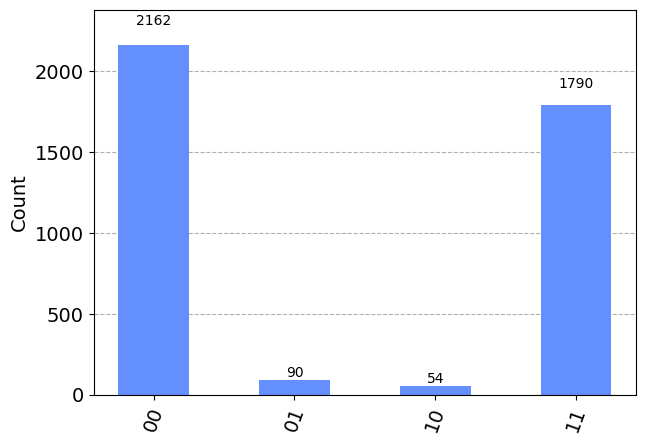

In [20]:
shots = 4096
transpiled_circuit = transpile(qc_nlocal, backend)
job = backend.run(transpiled_circuit, shots=shots)
counts_q = job.result().get_counts()
print(counts_q)
plot_histogram(counts_q)

{'11': 2039, '00': 2057}


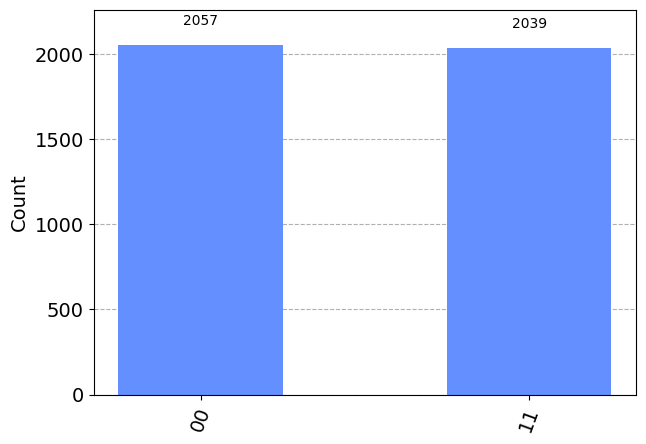

In [21]:
aer_sim = AerSimulator()
#cir = transpile(cir, aer_sim)
#cir.draw('mpl', style="iqp")
result_sim = aer_sim.run(transpiled_circuit, shots=shots).result()
countsU = result_sim.get_counts(transpiled_circuit)
print(countsU)
plot_histogram(countsU)